# Task 1: Visually Exploring a Dataset

**Type of Thesis:** Written Assignment  
**Course Name:** Explorative Data Analysis and Visualization  
**Course of Study:** Data Science  
**Author:** Dariia Sakhno  
**Matriculation Number:** IU14154916


<details> <summary><strong><span style="font-size:20px">Subtask: Data Loading and Preparation</span></strong></summary> <p><em>Short Explanation of Functions Used</em></p> <ul> <li><code>plt.style.use()</code> and <code>sns.set_context()</code> — <em>Set visual style and context for plots for better readability.</em></li> <li><code>pd.read_csv()</code> — <em>Loads dataset from a CSV file.</em></li> <li><code>expected_cols</code> — <em>Checks if required columns exist and lists any missing columns.</em></li> <li><code>pd.to_datetime(errors='coerce')</code> — <em>Converts the Date column to datetime, marking errors as NaT.</em></li> <li><code>pd.Categorical(..., ordered=True)</code> — <em>Creates ordered categorical data types for weekdays, months, and times of day to preserve logical order in analysis and plots.</em></li> <li><code>print()</code> — <em>Confirms successful loading and preparation of data.</em></li> </ul> </details>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualization style setup ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

# --- Load the dataset ---
df = pd.read_csv("/Users/dariiasakhno/anaconda_projects/032587b0-4ea3-48ff-8864-11b685ec5e8d/Coffe_sales.csv")

# --- Validate expected columns ---
expected_cols = [
    'hour_of_day', 'cash_type', 'money', 'coffee_name',
    'Time_of_Day', 'Weekday', 'Month_name',
    'Weekdaysort', 'Monthsort', 'Date', 'Time'
]
missing = [c for c in expected_cols if c not in df.columns]
print("Missing columns:", missing)

# --- Convert the 'Date' column to datetime safely ---
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# --- Create ordered categorical values for weekdays (based on Weekdaysort) ---
if {'Weekday', 'Weekdaysort'}.issubset(df.columns):
    order_wd = (
        df[['Weekday', 'Weekdaysort']]
        .dropna()
        .drop_duplicates()
        .sort_values('Weekdaysort')
    )['Weekday'].tolist()
    df['Weekday'] = pd.Categorical(df['Weekday'], categories=order_wd, ordered=True)

# --- Create ordered categorical values for months (based on Monthsort) ---
if {'Month_name', 'Monthsort'}.issubset(df.columns):
    order_month = (
        df[['Month_name', 'Monthsort']]
        .dropna()
        .drop_duplicates()
        .sort_values('Monthsort')
    )['Month_name'].tolist()
    df['Month_name'] = pd.Categorical(df['Month_name'], categories=order_month, ordered=True)

# --- Ensure the 'Time_of_Day' column has a clear logical order ---
if 'Time_of_Day' in df.columns:
    tod_order = ['Morning', 'Afternoon', 'Night']
    existing = [x for x in tod_order if x in df['Time_of_Day'].unique().tolist()]
    others = [x for x in df['Time_of_Day'].unique().tolist() if x not in existing]
    df['Time_of_Day'] = pd.Categorical(df['Time_of_Day'], categories=existing + others, ordered=True)

print("✅ Data successfully loaded and prepared for analysis.")


Missing columns: []
✅ Data successfully loaded and prepared for analysis.


In [2]:
start_date = pd.Timestamp('2024-03-03')
end_date = pd.Timestamp('2025-03-02')
df_year = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()

In [3]:
# ---------- 0️⃣ Filter data for the exact 1-year period ----------
# Define start and end dates for a full 12-month window
start_date = pd.Timestamp('2024-03-03')
end_date = pd.Timestamp('2025-03-02')

# Filter the dataset to include only the specified period
df_year = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()

# Display the actual date range after filtering
print("📅 Date range after filtering:", df_year['Date'].min(), "→", df_year['Date'].max())

# Create a 'Year_Month' column (useful for monthly aggregations)
df_year['Year_Month'] = df_year['Date'].dt.to_period('M')


📅 Date range after filtering: 2024-03-03 00:00:00 → 2025-03-02 00:00:00


<details> <summary><strong><span style="font-size:20px">Subtask: Monthly Revenue Calculation and Plot</span></strong></summary> <p><em>Short Explanation of Functions Used</em></p> <ul> <li><code>month_label(row)</code> — <em>This function marks March 2025 as a partial month because it only has two days, and formats other months as "Mon YYYY".</em></li> <li><code>df_year.apply()</code> — <em>Runs the month_label function on each row of the data to create a new label column.</em></li> <li><code>groupby()</code> — <em>Groups data by the new month label and sums up the revenue for each month.</em></li> <li><code>pd.to_datetime()</code> — <em>Converts the month labels to actual dates to allow correct sorting.</em></li> <li><code>sort_values()</code> — <em>Sorts the monthly revenue data in date order.</em></li> <li><code>sns.barplot()</code> — <em>Draws a bar chart showing total revenue each month, highlighting the partial March 2025.</em></li> <li><code>plt.figure(), plt.title(), plt.xlabel(), plt.ylabel(), plt.xticks()</code> — <em>Sets up the chart size, title, axis labels, and rotates the x-axis labels for better readability.</em></li> </ul> </details>

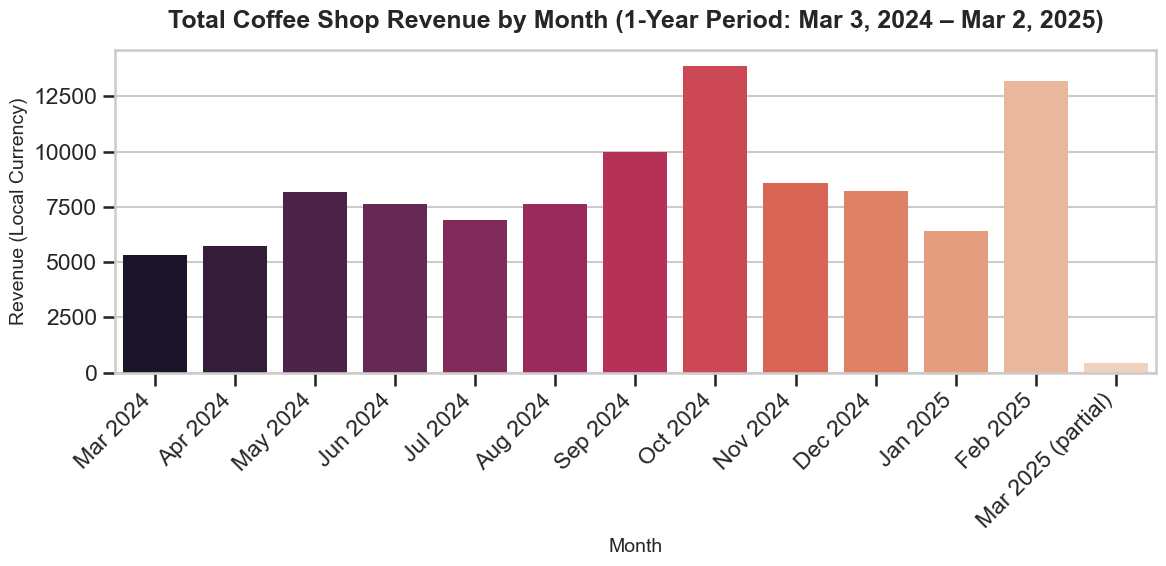

In [38]:
# --- Create a labeled month column (marking Mar 2025 as a partial month) ---
def month_label(row):
    # Label March 2025 separately since it only includes two days (01–02 Mar 2025)
    if row['Date'].year == 2025 and row['Date'].month == 3:
        return 'Mar 2025 (partial)'
    else:
        # Format all other months as "Mon YYYY" (e.g., "Mar 2024")
        return row['Date'].strftime('%b %Y')

# Apply the labeling function to each row
df_year['Month_Year_Label'] = df_year.apply(month_label, axis=1)

# --- Aggregate total revenue per labeled month ---
monthly_revenue = (
    df_year.groupby('Month_Year_Label', observed=True)['money']
    .sum()
    .reset_index()
)

# --- Add a helper column for chronological sorting ---
def parse_month_year(label):
    # Remove "(partial)" for date conversion
    clean_label = label.replace(' (partial)', '')
    return pd.to_datetime(clean_label, format='%b %Y', errors='coerce')

monthly_revenue['SortDate'] = monthly_revenue['Month_Year_Label'].apply(parse_month_year)

# --- Sort by date ---
monthly_revenue = monthly_revenue.sort_values('SortDate')

# --- Plot: Total monthly revenue (highlighting Mar 2025 partial month) ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=monthly_revenue,
    x='Month_Year_Label',
    y='money',
    hue='Month_Year_Label',       
    palette='rocket',
    legend=False                   # disable redundant legend
)

plt.title('Total Coffee Shop Revenue by Month (1-Year Period: Mar 3, 2024 – Mar 2, 2025)',
          fontsize=18, fontweight='bold', pad=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Revenue (Local Currency)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<details> <summary><strong><span style="font-size:20px">Subtask: Pie Chart of Coffee Purchases by Time of Day</span></strong></summary> <p><em>Short Explanation of Functions Used</em></p> <ul> <li><code>plt.figure(figsize=(7, 7))</code> — <em>This sets the size of the plot to a square 7x7 inches.</em></li> <li><code>plt.pie()</code> — <em>Creates a pie chart showing the proportion of coffee purchases by different times of the day.</em></li> <li><code>labels=time_counts.index</code> — <em>Sets the labels on the pie slices to the different times of day.</em></li> <li><code>autopct='%1.1f%%'</code> — <em>Displays the percentage value on each slice with one decimal place.</em></li> <li><code>startangle=90</code> — <em>Rotates the pie chart so the first slice starts at the top (90 degrees).</em></li> <li><code>colors=['red', 'green', 'orange']</code> — <em>Specifies different colors for each slice for easy distinction.</em></li> <li><code>wedgeprops={'edgecolor': 'black'}</code> — <em>Adds black edges to the slices to visually separate them.</em></li> <li><code>plt.title()</code> — <em>Adds a bold title for the chart with padding for better spacing.</em></li> <li><code>plt.show()</code> — <em>Displays the plot.</em></li> </ul> </details>

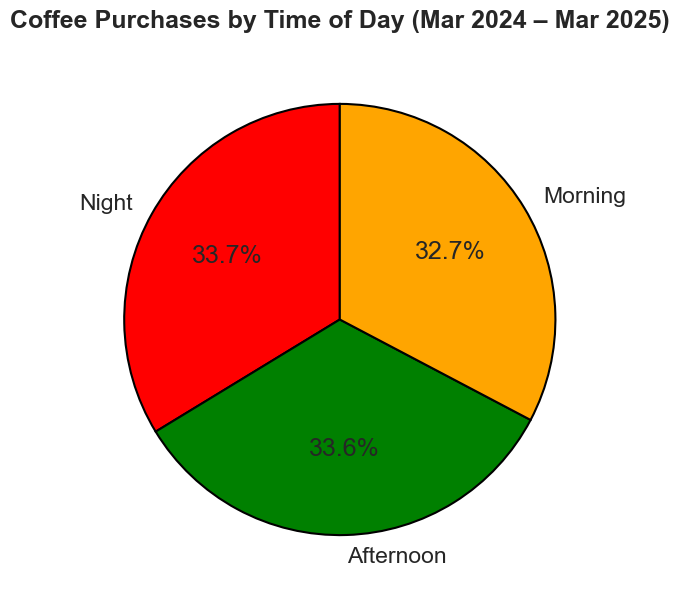

In [22]:
plt.figure(figsize=(7, 7))
plt.pie(
    time_counts,
    labels=time_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['red', 'green', 'orange'],  # different distinct colors
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Coffee Purchases by Time of Day (Mar 2024 – Mar 2025)', fontsize=18, fontweight='bold', pad=16)
plt.show()


<details>
  <summary><strong><span style="font-size:20px">
    Subtask: Heatmap — Coffee Type vs Month
  </span></strong></summary>

  <p><em>Short Explanation of Functions Used</em></p>

  <ul>
    <li><code>pd.read_csv()</code> — <em>loads the dataset from a CSV into a DataFrame</em>.</li>
    <li><code>groupby()</code> — <em>groups the data by month and coffee type to count occurrences</em>.</li>
    <li><code>pivot_table()</code> — <em>reformats grouped data into a matrix for the heatmap</em>.</li>
    <li><code>sns.heatmap()</code> — <em>creates the heatmap with color intensity showing patterns</em>.</li>
    <li><code>plt.figure(), plt.title(), plt.xlabel(), plt.ylabel()</code> — <em>set figure size and labels for readability</em>.</li>
  </ul>
</details>


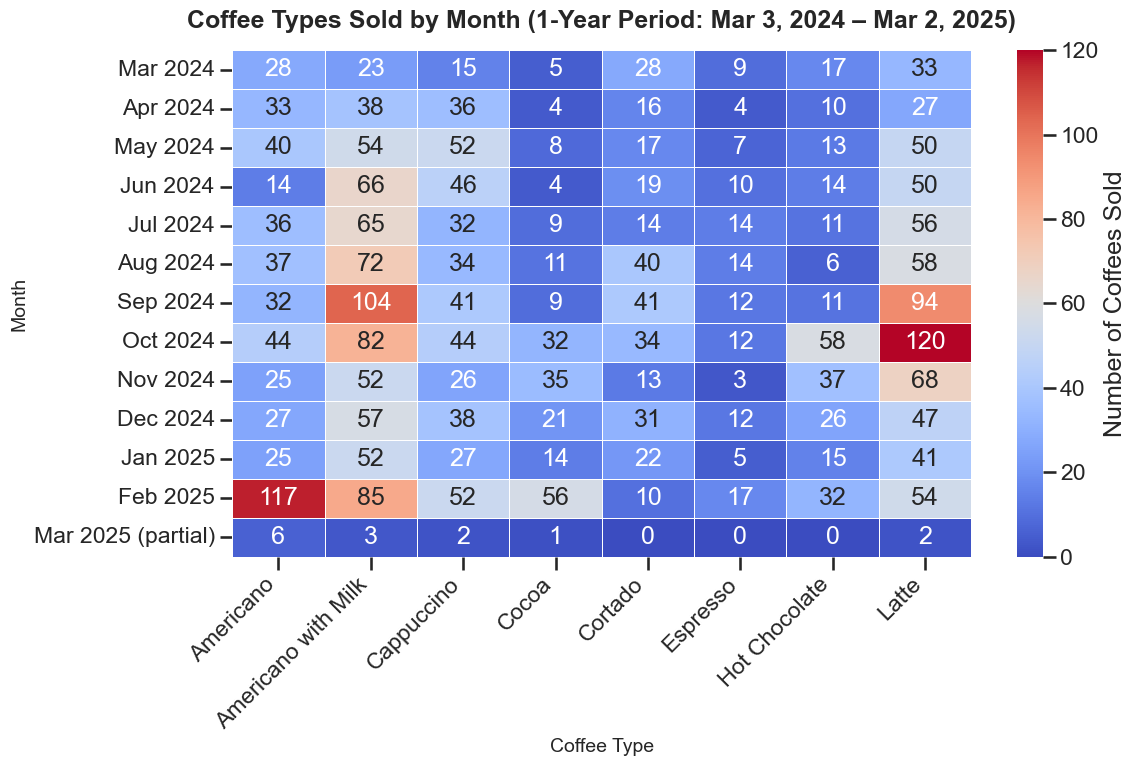

In [7]:
# --- Plot: Coffee types sold by month (heatmap) ---
# Aggregate data: count number of coffee sales per month per coffee type
heat_map = (
    df_year
    .groupby(['Month_Year_Label', 'coffee_name'])
    .size()
    .unstack(fill_value=0)
)

# Sort months chronologically (if labels are not already ordered)
heat_map = heat_map.loc[
    sorted(heat_map.index, key=lambda x: pd.Period(x.replace(' (partial)', ''), freq='M'))
]

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heat_map,
    cmap='coolwarm',
    annot=True,
    fmt='d',
    linewidths=0.5,
    cbar_kws={'label': 'Number of Coffees Sold'}
)

plt.title('Coffee Types Sold by Month (1-Year Period: Mar 3, 2024 – Mar 2, 2025)',
          fontsize=18, fontweight='bold', pad=16)
plt.xlabel('Coffee Type', fontsize=14)
plt.ylabel('Month', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<details> <summary><strong><span style="font-size:20px">Subtask: Monthly Coffee Sales Count and Plot</span></strong></summary> <p><em>Short Explanation of Functions Used</em></p> <ul> <li><code>groupby('Year_Month').size()</code> — <em>Groups coffee sales by each month and counts how many sales happened in each month.</em></li> <li><code>reset_index(name='num_sales')</code> — <em>Turns the grouped counts into a new DataFrame column named 'num_sales'.</em></li> <li><code>sort_values('num_sales', ascending=False)</code> — <em>Sorts months from highest to lowest number of sales.</em></li> <li><code>sns.barplot()</code> — <em>Creates a bar chart showing number of sales per month, sorted so peak months come first.</em></li> <li><code>hue=monthly_sales['Year_Month'].astype(str)</code> — <em>Assigns color for each bar by month to avoid warnings.</em></li> <li><code>plt.figure(), plt.title(), plt.xlabel(), plt.ylabel(), plt.xticks(), plt.tight_layout()</code> — <em>Sets chart size, labels, title, rotates x-axis labels, and adjusts layout for clarity.</em></li> <li><code>plt.show()</code> — <em>Displays the plot.</em></li> </ul> </details>

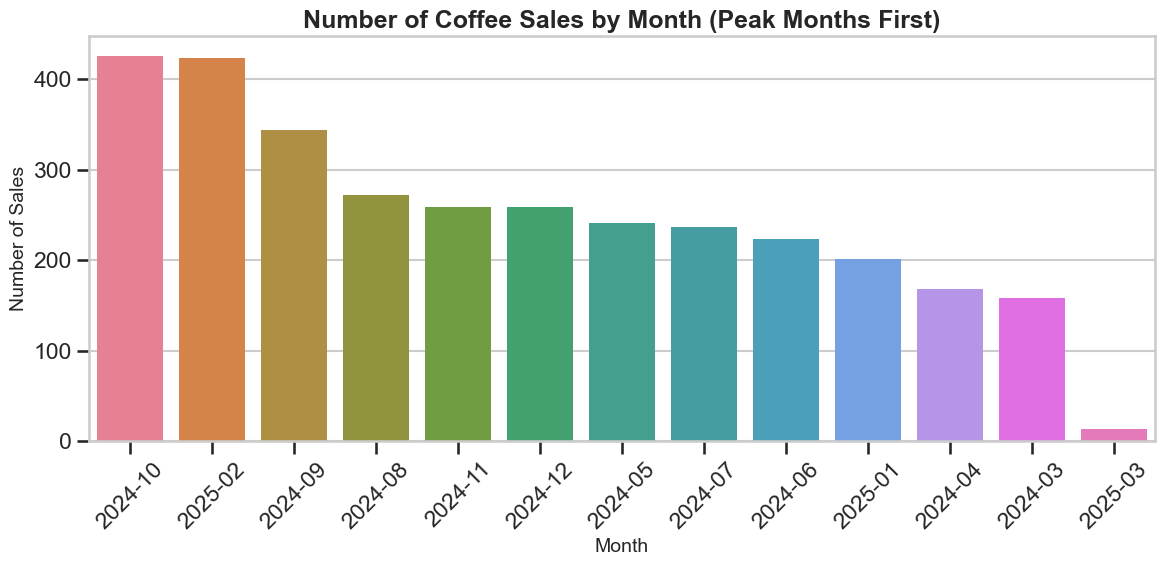

In [23]:
# --- Aggregate sales count per month ---
monthly_sales = (
    df_year.groupby('Year_Month')
    .size()
    .reset_index(name='num_sales')
)

# --- Sort by number of sales descending (highest first) ---
monthly_sales = monthly_sales.sort_values('num_sales', ascending=False)

# --- Plot: Number of Coffee Sales by Month (highest first) ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=monthly_sales,
    x=monthly_sales['Year_Month'].astype(str),
    y='num_sales',
    hue=monthly_sales['Year_Month'].astype(str),  # assign hue to avoid FutureWarning
    palette='husl',
    dodge=False,
    legend=False  # disable redundant legend
)

plt.title('Number of Coffee Sales by Month (Peak Months First)', fontsize=18, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Sales', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<details> <summary><strong><span style="font-size:20px">Subtask: Coffee Sales by Weekday Barplot</span></strong></summary> <p><em>Short Explanation of Functions Used</em></p> <ul> <li><code>plt.style.use('seaborn-v0_8-whitegrid')</code> — <em>Sets a clean white grid style for the plot using seaborn's predefined theme.</em></li> <li><code>sns.set_context('talk')</code> — <em>Adjusts plot elements to be clearer for presentations or talks.</em></li> <li><code>value_counts().reindex()</code> — <em>Counts how many sales happened on each weekday, reordered to match the correct weekday order.</em></li> <li><code>sns.barplot()</code> — <em>Draws a bar chart with sales counts by weekday, colored using a bright color palette.</em></li> <li><code>hue=weekday_sales.index</code> — <em>Assigns color by weekday for consistent palette mapping.</em></li> <li><code>plt.title(), plt.xlabel(), plt.ylabel()</code> — <em>Add title and axis labels with bigger font for readability.</em></li> <li><code>plt.tight_layout()</code> — <em>Automatically adjusts plot layout to reduce overlaps.</em></li> <li><code>plt.show()</code> — <em>Displays the final bar chart.</em></li> </ul> </details>

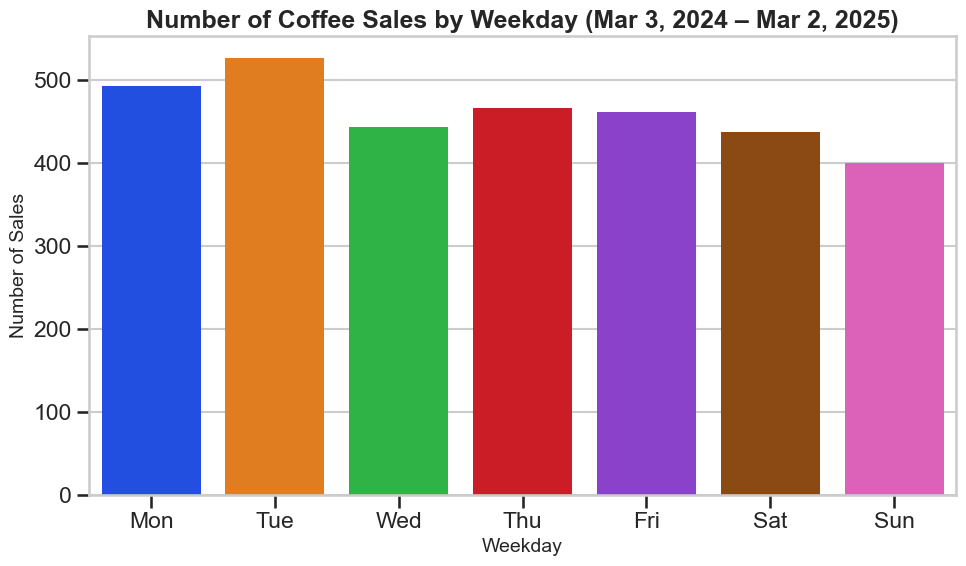

In [24]:
# --- Number of Coffee Sales by Weekday ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

plt.figure(figsize=(10,6))

# Count sales per weekday in the proper order
weekday_sales = df_year['Weekday'].value_counts().reindex(df_year['Weekday'].cat.categories)

# Barplot with hue for palette compatibility
sns.barplot(
    x=weekday_sales.index,
    y=weekday_sales.values,
    hue=weekday_sales.index,     # hue enables correct color palette
    palette='bright',            # bright, vivid colors
    legend=False                 # remove redundant legend
)

plt.title('Number of Coffee Sales by Weekday (Mar 3, 2024 – Mar 2, 2025)', fontsize=18, fontweight='bold')
plt.xlabel('Weekday', fontsize=14)
plt.ylabel('Number of Sales', fontsize=14)
plt.tight_layout()
plt.show()

<details> <summary><strong><span style="font-size:20px">Subtask: Top-Selling Coffee Products Bar Chart</span></strong></summary> <p><em>Short Explanation of Functions Used</em></p> <ul> <li><code>pd.Timestamp()</code> — <em>Defines the start and end dates for filtering data to a single year.</em></li> <li><code>value_counts().head(top_n)</code> — <em>Finds the top 10 most sold coffee types by counting transactions.</em></li> <li><code>sns.color_palette("turbo")</code> — <em>Chooses a bright color palette for the bars.</em></li> <li><code>sns.countplot()</code> — <em>Draws a bar chart counting sales of each coffee type, using specified order and palette.</em></li> <li><code>ax.set_title(), ax.set_xlabel(), ax.set_ylabel()</code> — <em>Sets title and axis labels with readable font sizes.</em></li> <li><code>plt.xticks(rotation=45, ha='right')</code> — <em>Rotates x-axis labels for better readability.</em></li> <li><code>ax.annotate()</code> — <em>Adds count and percentage labels above each bar for more information.</em></li> <li><code>plt.tight_layout()</code> — <em>Automatically adjusts spacing so nothing overlaps.</em></li> <li><code>plt.show()</code> — <em>Displays the finished plot.</em></li> </ul> </details>

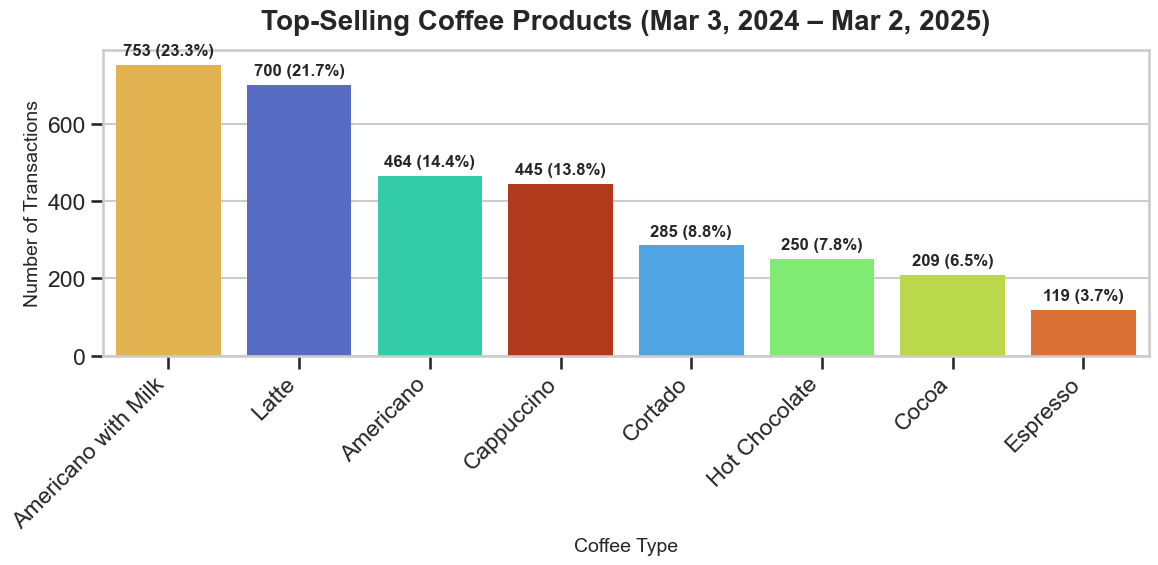

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter to the exact one-year period
start_date = pd.Timestamp('2024-03-03')
end_date = pd.Timestamp('2025-03-02')
df_year = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()

# Select top 10 coffee types
top_n = 10
counts = df_year['coffee_name'].value_counts().head(top_n)
order = counts.index.tolist()

# Vibrant and visually appealing color palette
palette = sns.color_palette("turbo", n_colors=len(order))

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

# Create the figure
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=df_year[df_year['coffee_name'].isin(order)],
    x='coffee_name',
    hue='coffee_name',  # Required for Seaborn 0.14+ when using palette
    order=order,
    palette=palette,
    legend=False
)

# Titles and labels
ax.set_title('Top-Selling Coffee Products (Mar 3, 2024 – Mar 2, 2025)', fontsize=20, fontweight='bold', pad=15)
ax.set_xlabel('Coffee Type', fontsize=14)
ax.set_ylabel('Number of Transactions', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Annotate bars with counts and percentages
total_sales = len(df_year)
for p in ax.patches:
    count = int(p.get_height())
    percent = count / total_sales * 100
    ax.annotate(
        f"{count} ({percent:.1f}%)",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom',
        fontsize=12, fontweight='semibold',
        xytext=(0, 5), textcoords='offset points'
    )

# Improve layout
plt.tight_layout()
plt.show()

# plt.savefig('top_selling_coffee_products.png', dpi=300, bbox_inches='tight')

<details> <summary><strong><span style="font-size:20px">Subtask: Basic Stats and Correlation Analysis</span></strong></summary> <p><em>Short Explanation of Functions Used</em></p> <ul> <li><code>pd.read_csv()</code> — <em>Loads the coffee sales data from a CSV file into a DataFrame.</em></li> <li><code>rename(columns={})</code> — <em>Renames the 'money' column to 'Price' for clarity.</em></li> <li><code>describe()</code> — <em>Computes basic stats (count, mean, std, min, max) for the Price and hour_of_day columns.</em></li> <li><code>corr()</code> — <em>Calculates the correlation matrix showing how Price and hour_of_day relate linearly.</em></li> <li><code>cov()</code> — <em>Calculates the covariance matrix to measure the joint variability between Price and hour_of_day.</em></li> <li><code>print()</code> — <em>Displays the computed statistics and matrices to the console.</em></li> </ul> </details>

In [2]:
import pandas as pd

df = pd.read_csv("/Users/dariiasakhno/anaconda_projects/032587b0-4ea3-48ff-8864-11b685ec5e8d/Coffe_sales.csv")
df = df.rename(columns={'money': 'Price'})

# Calculate basic statistics like mean and spread for Price and hour_of_day
basic_stats = df[['Price', 'hour_of_day']].describe()
print("Basic statistics:")
print(basic_stats)

# Calculate the correlation between Price and hour_of_day
correlation = df[['Price', 'hour_of_day']].corr()
print("\nCorrelation matrix:")
print(correlation)

# Calculate the covariance between Price and hour_of_day
covariance = df[['Price', 'hour_of_day']].cov()
print("\nCovariance matrix:")
print(covariance)


Basic statistics:
             Price  hour_of_day
count  3547.000000  3547.000000
mean     31.645216    14.185791
std       4.877754     4.234010
min      18.120000     6.000000
25%      27.920000    10.000000
50%      32.820000    14.000000
75%      35.760000    18.000000
max      38.700000    22.000000

Correlation matrix:
                Price  hour_of_day
Price        1.000000     0.202748
hour_of_day  0.202748     1.000000

Covariance matrix:
                 Price  hour_of_day
Price        23.792481     4.187243
hour_of_day   4.187243    17.926837
